In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys
sys.path.append('src')
from poisson_disk import PoissonDiskSampler
%aimport settings
import settings
%aimport cnn_utils
import cnn_utils
%aimport geometry_utils
import geometry_utils
%aimport dataset_utils
import dataset_utils

import numpy as np
import cv2
import matplotlib
import matplotlib.pylab as plt

from sklearn.externals import joblib
import skimage
import scipy.stats
sys.path.append(settings.CAFFE_PYTHON_PATH)
import caffe
%matplotlib inline

/home/yasser/.virtualenvs/sci/local/lib/python2.7/site-packages/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/yasser/.virtualenvs/sci/local/lib/python2.7/site-packages/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/yasser/.virtualenvs/sci/local/lib/python2.7/site-packages/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [3]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'

In [4]:
cub = dataset_utils.CUB_200_2011()
cub_annotations = dataset_utils.BerkeleyAnnotaionHelper(cub)
IDtrain, IDtest = cub.train_test_id()
imgs_addr = cub.image_addrs()

dh = cnn_utils.DeepHelper()

6


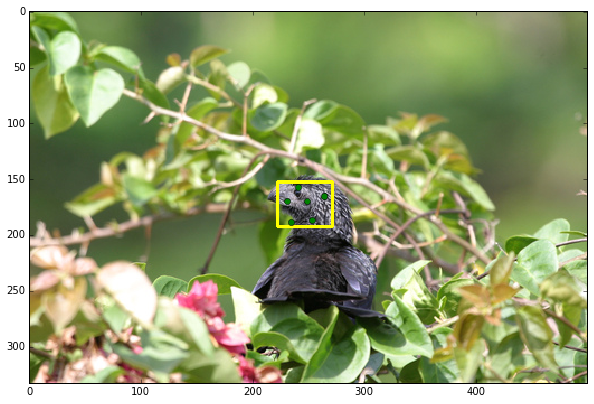

In [5]:
part = 'head'
radius = 15
fig = plt.figure()
ax = fig.add_subplot(111)

img_id = IDtrain[95]

img = caffe.io.load_image(imgs_addr[img_id])
box = cub_annotations.annotation(img_id, part)

dh.init_with_image(img)

positive_points = box.generate_points_inside(param=radius, img=img)

geometry_utils.draw_points(positive_points, ax, color='green')
print len(positive_points)
ax.imshow(box.draw_box(img, (1, 1, 0)))

67


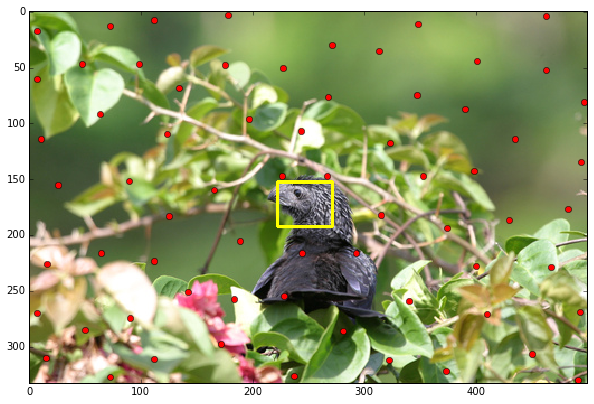

In [6]:
part = 'head'
radius = 40
fig = plt.figure()
ax = fig.add_subplot(111)

img_id = IDtrain[95]

img = caffe.io.load_image(imgs_addr[img_id])
box = geometry_utils.Box.box_from_img(img)
box_head = cub_annotations.annotation(img_id, part)

dh.init_with_image(img)

negative_points = box.generate_points_inside(param=radius, img=img)
negative_points = geometry_utils.filter_points(negative_points, box_head)

geometry_utils.draw_points(negative_points, ax, color='red')
print len(negative_points)
ax.imshow(box_head.draw_box(img, (1, 1, 0)))

In [7]:
def image_features(img_id, part, part_radius, box_radius, ax):
    img = caffe.io.load_image(imgs_addr[img_id])
    box = geometry_utils.Box.box_from_img(img)
    box_part = cub_annotations.annotation(img_id, part)
    dh.init_with_image(img)
    
    positive_points = box_part.generate_points_inside(param=part_radius)
    
    negative_points = box.generate_points_inside(param=box_radius, img=img)
    negative_points = geometry_utils.filter_points(negative_points, box_part)
    
    geometry_utils.draw_points(positive_points, ax, color='green')
    geometry_utils.draw_points(negative_points, ax, color='red')
    
    ax.imshow(box_part.draw_box(img, (1, 1, 0)))
    
    print len(positive_points), len(negative_points)

7 94


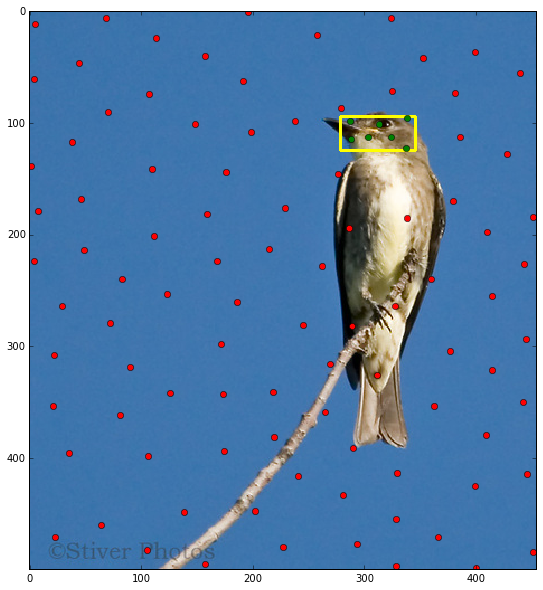

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

image_features(IDtrain[1195], 'head', 15, 40, ax)

In [9]:
img_id = IDtrain[1195]
part = 'head'
part_box = cub_annotations.annotation(img_id, part)
img = caffe.io.load_image(imgs_addr[img_id])
pos, neg = dh.image_point_features(img, part_box, part)

In [10]:
pos.shape, neg.shape

((7, 1376), (92, 1376))

## loading the model and detecting

In [11]:
model = joblib.load('detectors/test_model.mdl')

In [12]:
def _post_process_preds(preds):
    preds = skimage.morphology.closing(preds, skimage.morphology.square(10))
    preds = skimage.morphology.remove_small_objects(preds, min_size=10, connectivity=1)
    return preds
def _find_rect_from_preds(preds):
    L, N = skimage.measure.label(preds, return_num=True, background=0)
    if N > 0:
        L_no_bg = L[L != -1].flatten()
        vals, counts = scipy.stats.mode(L_no_bg)
        part_label = int(vals[0])

        indices = np.where(L == part_label)
        xmin = indices[0].min()
        xmax = indices[0].max()
        ymin = indices[1].min()
        ymax = indices[1].max()

        return geometry_utils.Box(xmin, xmax, ymin, ymax)
    else:
        return geometry_utils.Box(-1, -1, -1, -1)

In [26]:
def vis(preds_prob, img):
    fig = plt.figure(figsize=(10, 10))
    
    preds_prob_resize = cv2.resize(preds_prob, (img.shape[1], img.shape[0]))

    img_gray = skimage.color.rgb2gray(img)

    ax = fig.add_subplot(111)
    cax = ax.matshow(preds_prob_resize, cmap=plt.cm.Reds, alpha=1)
    ax.imshow(img_gray, alpha=0.3, cmap=plt.cm.gray)
    
    fig.colorbar(cax)
    ax.axis('off')

1


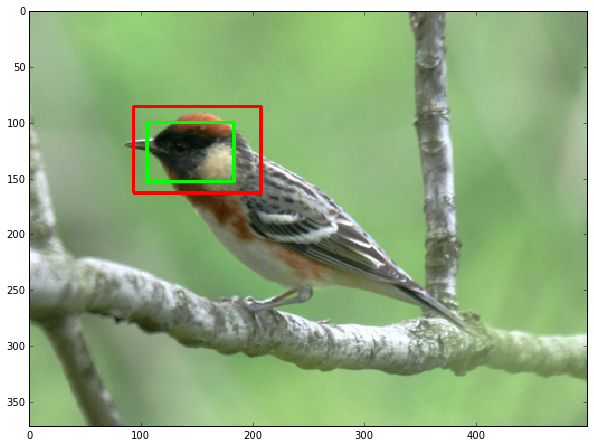

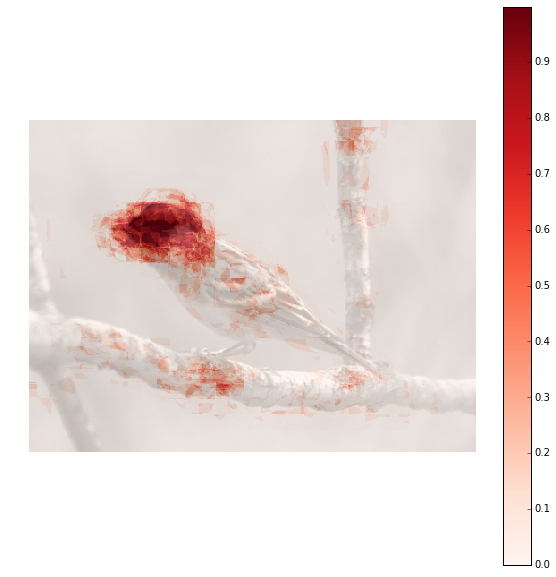

In [31]:
img_id = IDtest[4526]
part_name = 'head'

img = caffe.io.load_image(imgs_addr[img_id])
part_box = cub_annotations.annotation(img_id, part_name)

dh.init_with_image(img)
Xtest = dh.ffeats.reshape(dh.ffeats.shape[0] * dh.ffeats.shape[1], dh.ffeats.shape[2])
preds = model.predict(Xtest)
preds_prob = model.predict_proba(Xtest)
preds_img = preds.reshape(dh.ffeats.shape[0], dh.ffeats.shape[1])
preds_prob_image = preds_prob[:, 1].reshape(dh.ffeats.shape[0], dh.ffeats.shape[1])

pred_box = _find_rect_from_preds(_post_process_preds(preds_img))

plt.imshow(pred_box.draw_box(part_box.draw_box(img, color=(0, 1, 0)), color=(1, 0, 0)))

vis(preds_prob_image, img)

print pred_box.evalPCP(part_box, img.shape, thresh=0.4)

## Testing on a out of dataset image

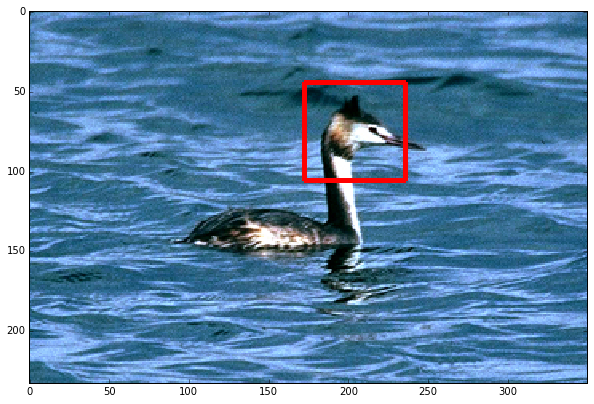

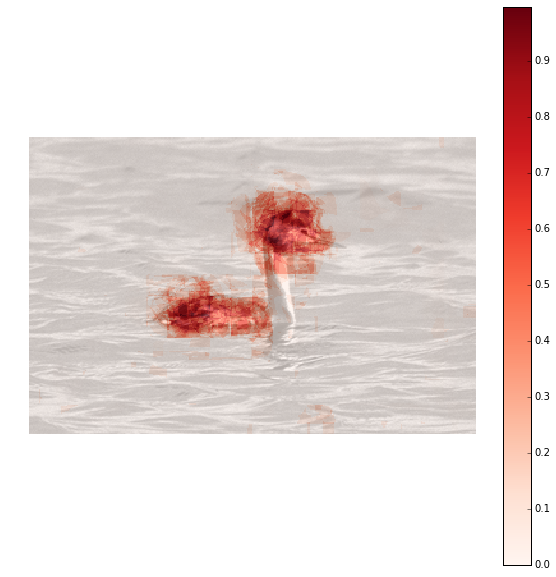

In [35]:
image_addr = '/home/yasser/Downloads/Bird/001.Great_Crested_Grebe/Great_Crested_Grebe_001.jpg'
img = caffe.io.load_image(image_addr)

dh.init_with_image(img)
Xtest = dh.ffeats.reshape(dh.ffeats.shape[0] * dh.ffeats.shape[1], dh.ffeats.shape[2])
preds = model.predict(Xtest)
preds_prob = model.predict_proba(Xtest)
preds_img = preds.reshape(dh.ffeats.shape[0], dh.ffeats.shape[1])
preds_prob_image = preds_prob[:, 1].reshape(dh.ffeats.shape[0], dh.ffeats.shape[1])

pred_box = _find_rect_from_preds(_post_process_preds(preds_img))

plt.imshow(pred_box.draw_box(img, color=(1, 0, 0)))
vis(preds_prob_image, img)

## Evaluate PCP on the CUB dataset

In [ ]:
part_name = 'head'
preds_boxes = {}
S = 0
for i, img_id in enumerate(IDtest):
    img = caffe.io.load_image(imgs_addr[img_id])
    part_box = cub_annotations.annotation(img_id, part_name)

    dh.init_with_image(img)
    Xtest = dh.ffeats.reshape(dh.ffeats.shape[0] * dh.ffeats.shape[1], dh.ffeats.shape[2])
    preds = model.predict(Xtest)
    preds_prob = model.predict_proba(Xtest)
    preds_img = preds.reshape(dh.ffeats.shape[0], dh.ffeats.shape[1])
    preds_prob_image = preds_prob[:, 1].reshape(dh.ffeats.shape[0], dh.ffeats.shape[1])

    pred_box = _find_rect_from_preds(_post_process_preds(preds_img))
    preds_boxes[img_id] = pred_box
    
    S += pred_box.evalPCP(part_box, img.shape, thresh=0.5)